# Neural Networks

An artificial neural network (or neural network for short) is a ***predictive*** model motivated by the way the brain operates.

**Perceptron**, approximates a single neuron with *n* binary inputs.

My conclusion:

* Each neuron is a ***linear*** model. Represent each neuron as:

n<sub>ij</sub> = *y<sub>ij</sub> = w<sub>1</sub> x<sub>(i-)1</sub> + . . . + w<sub>k</sub> x<sub>(i-1)k</sub> + b<sub>(i-1)</sub>*

where
* *i* = layer
* *j* = neuron in layer
* *k* = number of neurons in the previous layer

In [1]:
import random
import tqdm
from typing import List

from matplotlib import pyplot as plt

from ch04_linear_algebra import Vector
from ch08_gradient_descent import gradient_step
from ch18_neural_networks import feed_forward
from ch18_neural_networks import perceptron_output
from ch18_neural_networks import sigmoid
from ch18_neural_networks import sqerror_gradients
from ch18_neural_networks import step_function


# Perceptrons
Pretty much the simplest neural network is the ***perceptron***, which approximates a single neuron with n binary inputs. It computes a weighted sum of its inputs and “fires” if that weighted sum is zero or greater.

The perceptron is simply distinguishing between the half spaces separated by the
hyperplane of points x for which:

`dot(weights,x) + bias == 0`


However, there are some problems that simply can’t be solved by a single perceptron. For example, no matter how hard you try, you cannot use a perceptron to build an XOR gate that outputs 1 if exactly one of its inputs is 1 and 0 otherwise. This is where we start needing more-complicated neural networks.

Artificial neurons

* Perceptrons. The perceptron neuron has inputs, x1,x2,…. Inputs can only be 0 or 1. Has weights for each input, w1,w2,…, and an overall bias. Output is 0 or  1
* Sigmoid. The sigmoid neuron has inputs, x1,x2,…. But instead of being just 0 or 1, these inputs can also take on any values between 0 and 1. Has weights for each input, w1,w2,…, and an overall bias. Output is not 0 or  1. nstead, it's σ(w⋅x+b), where σ is called the sigmoid function. Continuous value between 0 and 1.

\begin{eqnarray} 
  \frac{1}{1+e^(-\sum_j w_j x_j-b)}.
\tag{4}\end{eqnarray}

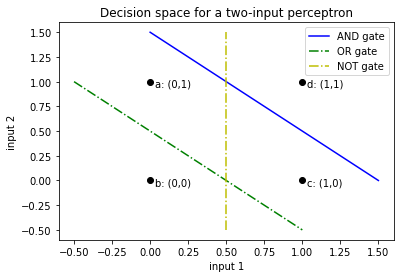

AND gate
For weights [2.0, 2] and bias -3.0
perceptron output for [0, 1] is: 0.0
perceptron output for [0, 0] is: 0.0
perceptron output for [1, 0] is: 0.0
perceptron output for [1, 1] is: 1.0
OR gate
For weights [1, 1] and bias -1.0
perceptron output for [0, 1] is: 1.0
perceptron output for [0, 0] is: 0.0
perceptron output for [1, 0] is: 1.0
perceptron output for [1, 1] is: 1.0
NOT gate
For weights [-2] and bias 1
perceptron output for [0] is: 1.0
perceptron output for [1] is: 0.0


In [6]:
# AND, OR and NOT logical gates realized as a perceptor

# AND gate x-axis and y-axis values
xs_and = [0, 1.5]
ys_and = [1.5, 0]

# OR gate x-axis and y-axis values
xs_or = [-0.5, 1]
ys_or = [1, -0.5]

# NOT gate x-axis and y-axis values
xs_not = [0.5, 0.5]
ys_not = [-0.5, 1.5]

# unit reference points x-axis and y-axis values
xs_inputs = [0, 0, 1, 1]
ys_inputs = [1, 0, 0, 1]
label_inputs = ['a: (0,1)', 'b: (0,0)', 'c: (1,0)', 'd: (1,1)']

# generate a line charts 
plt.plot(xs_and, ys_and, 'b-', label='AND gate')
plt.plot(xs_or, ys_or, 'g-.', label='OR gate')
plt.plot(xs_not, ys_not, 'y-.', label='NOT gate')

# generate scatter plot with the unit reference points
plt.scatter(xs_inputs, ys_inputs, color='black')
# label each point
for label, x, y in zip(label_inputs, xs_inputs, ys_inputs):
    plt.annotate(label,
        xy=(x, y),    # put the label with its point
        xytext=(5, -5),                     # but slightly offset
        textcoords='offset points')

# labels, title and show
#plt.figure(figsize=(10,12))
plt.legend(loc='upper right')
plt.xlabel("input 1")
plt.ylabel("input 2")
plt.title("Decision space for a two-input perceptron")
plt.show()



a = [0,1]
b = [0,0]
c = [1,0]
d = [1,1]
inputs = [a, b, c, d]

binary_zero = [0]
binary_one = [1]
binary_inputs = [ binary_zero, binary_one]

# AND gate
and_weights = [2., 2]
and_bias = -3.

# OR gate
or_weights = [1, 1]
or_bias = -1.

# OR gate, another
or2_weights = [2, 2]
or2_bias = -1.

# NOT gate
not_weights = [-2]
not_bias = 1

def report_perceptor_output(inputs: list, weights: Vector, bias: float) -> None:
    print('For weights', weights, 'and bias', bias)
    for i in inputs:
        print('perceptron output for', i, 'is:', perceptron_output(weights, bias, i))

print('AND gate')
report_perceptor_output(inputs, and_weights, and_bias)
print('OR gate')
report_perceptor_output(inputs, or_weights, or_bias)
print('NOT gate')
report_perceptor_output(binary_inputs, not_weights, not_bias)

## Feed-Forward Neural Networks

A **feed-forward** neural network consists of discrete layers of neurons, each connected to the next. This typically entails an *input* layer (which receives inputs and feeds them forward unchanged), one or more “*hidden layers*” (each of which consists of neurons that take the outputs of the previous layer, performs some calculation, and passes the result to the next layer), and an *output* layer (which produces the final outputs).

Just like the perceptron, each (noninput) neuron has a weight corresponding to each of its inputs and a bias. To make our representation simpler, we’ll add the bias to the end of our weights vector and give each neuron a bias input that always equals 1.

Why use sigmoid instead of the simpler step_function? In order to train a neural network, we’ll need to use calculus, and in order to use calculus, we need *smooth* functions. The step function isn’t even continuous, and sigmoid is a good smooth approximation of it.

We then calculate the output as:

```python
def neuron_output(weights: Vector, inputs: Vector) -> float:
    # weights includes the bias term, inputs includes a 1
    return sigmoid(dot(weights, inputs))
``` 

Given this function, we can represent a neuron simply as a list of weights whose
length is one more than the number of inputs to that neuron (because of the bias
weight). Then we can represent a neural network as a list of (noninput) layers, where
each layer is just a list of the neurons in that layer.

That is, we’ll represent a neural network as a list (layers) of lists (neurons) of lists
(weights).

```bash
# if an AND gate perceptor has these parameters 
and_weights = [2., 2]
and_bias = -3.

# the neural network looks like:
and_gate =
[                       # list of layers
    [                   # list of neurons in layer
        [2, 2, -3]      # list of weights in neuron
    ]
]
```

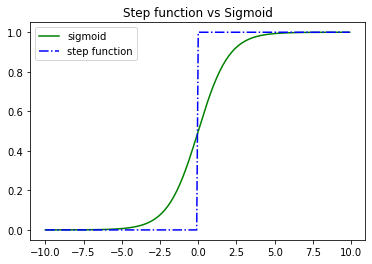

In [7]:
#
# Graph the Sigmoid and Step functions
#

# x-axis values
xs = [i/10 for i in range(-100, 100, 1)]

# y-axis values, Sigmoid function values
ys_sigmoid = [sigmoid(x) for x in xs]
# y-axis values, Step function values
ys_step_function = [step_function(x) for x in xs]

# create a line chart for the Sigmoid function, and another for the Step function 
plt.plot(xs, ys_sigmoid, 'g-', label='sigmoid')
plt.plot(xs, ys_step_function, 'b-.', label='step function')

# set labels, title and show
plt.legend(loc='upper left')
plt.title("Step function vs Sigmoid")
plt.show()

Now it’s easy to build the XOR gate that we couldn’t build with a single perceptron. We just need to scale the weights up so that the *neuron_output*s are either really close to 0 or really close to 1:

In [8]:
#
# XOR gate represented as a neural network
# network is built manually


xor_network = [# hidden layer
               [[20., 20, -30],      # 'and' neuron
                [20., 20, -10]],     # 'or'  neuron
               # output layer
               [[-60., 60, -30]]]    # '2nd input but not 1st input' neuron

# feed_forward returns the outputs of all layers, so the [-1] gets the
# final output, and the [0] gets the value out of the resulting vector
assert 0.000 < feed_forward(xor_network, [0, 0])[-1][0] < 0.001
assert 0.999 < feed_forward(xor_network, [1, 0])[-1][0] < 1.000
assert 0.999 < feed_forward(xor_network, [0, 1])[-1][0] < 1.000
assert 0.000 < feed_forward(xor_network, [1, 1])[-1][0] < 0.001

for x_1 in [0, 1]:          # dimension 1
    for x_2 in [0, 1]:      # dimension 2
        # feed_forward produces the outputs of every neuron
        # feed_forward[-1] is the outputs of the output-layer neurons
        #print(x, y, feed_forward(xor_network,[x, y])[-1])
        my_output = feed_forward(xor_network,[x_1, x_2])[-1][0]
        round_output = round(my_output)
        print('XOR gate of', str([x_1, x_2]) , 'is: ', str(round_output), '(the round of sigmoid:', str(my_output), ')')

# 0 0 [9.38314668300676e-14]
# 0 1 [0.9999999999999059]
# 1 0 [0.9999999999999059]
# 1 1 [9.383146683006828e-14]

XOR gate of [0, 0] is:  0 (the round of sigmoid: 9.38314668300676e-14 )
XOR gate of [0, 1] is:  1 (the round of sigmoid: 0.9999999999999059 )
XOR gate of [1, 0] is:  1 (the round of sigmoid: 0.9999999999999059 )
XOR gate of [1, 1] is:  0 (the round of sigmoid: 9.383146683006828e-14 )


## Backpropagation

Backpropagation, algorithm to train for neural networks. It has similarities to the gradient descent algorithm.

Imagine we have a training set that consists of input vectors and corresponding target output vectors.
Imagine that our network has some set of weights.

We then adjust the weights using the following algorithm:

• Run feed_forward on an input vector to produce the outputs of all the neurons in the network.

• We know the target output, so we can compute a loss that’s the sum of the squared errors.

• Compute the gradient of this loss as a function of the output neuron’s weights.

• “Propagate” the gradients and errors backward to compute the gradients with respect to the hidden neurons’ weights.

• Take a gradient descent step.
Typically we run this algorithm many times for our entire training set until the network converges.

In [9]:
#
# Backpropagation
# network is trained

from ch18_neural_networks import backpropagate
# training data for XOR network
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]
    
# start with random weights
network = [ # hidden layer: 2 inputs -> 2 outputs
    [[random.random() for _ in range(2 + 1)],   # 1st hidden neuron
    [random.random() for _ in range(2 + 1)]],   # 2nd hidden neuron
    # output layer: 2 inputs -> 1 output
    [[random.random() for _ in range(2 + 1)]]   # 1st output neuron
]

learning_rate = 1.0

for epoch in tqdm.trange(20000, desc="neural net for xor"):
    for x, y in zip(xs, ys):
        gradients = sqerror_gradients(network, x, y)
        #gradients = backpropagate(network, x, y)

        # Take a gradient step for each neuron in each layer
        network = [[gradient_step(neuron, grad, -learning_rate)
                    for neuron, grad in zip(layer, layer_grad)]
                   for layer, layer_grad in zip(network, gradients)]

print('\r', network)
num_layers = len(network)
print('The network has', num_layers, 'layers')
for l, layer in enumerate(network):
    num_neurons = len(layer)
    print('layer:', l, 'has', num_neurons, 'neurons')
    for n, neuron in enumerate(layer):
        num_weights = len(neuron)
        print('layer', l, ', neuron:', n, 'has', num_weights, 'weights')
        for w, weight in enumerate(neuron):
            print('layer', l, ', neuron:', n, 'weight', w, 'is:', weight)
print('\rThe network looks like:', network)
    

print('\nBackpropagation has finished training the neural network. \nThese are the results:')
for x_1 in [0, 1]:          # dimension 1
    for x_2 in [0, 1]:      # dimension 2
        # feed_forward produces the outputs of every neuron
        # feed_forward[-1] is the outputs of the output-layer neurons
        #print(x, y, feed_forward(xor_network,[x, y])[-1])
        my_output = feed_forward(network,[x_1, x_2])[-1][0]
        round_output = round(my_output)
        print('Trained XOR gate output of', str([x_1, x_2]) , 'is:', str(round_output), '(the round of sigmoid:', str(my_output), ')')

# check that it learned XOR -> we are testing in the same set used for training!!
assert feed_forward(network, [0, 0])[-1][0] < 0.01
assert feed_forward(network, [0, 1])[-1][0] > 0.99
assert feed_forward(network, [1, 0])[-1][0] > 0.99
assert feed_forward(network, [1, 1])[-1][0] < 0.01

 [[[-5.282465140547846, -5.287274338395276, 7.884953581267338], [-6.862722080224268, -6.888619121549629, 2.887747294284171]], [[11.188518558798467, -11.310332840971542, -5.35907006704807]]]
The network has 2 layers
layer: 0 has 2 neurons
layer 0 , neuron: 0 has 3 weights
layer 0 , neuron: 0 weight 0 is: -5.282465140547846
layer 0 , neuron: 0 weight 1 is: -5.287274338395276
layer 0 , neuron: 0 weight 2 is: 7.884953581267338
layer 0 , neuron: 1 has 3 weights
layer 0 , neuron: 1 weight 0 is: -6.862722080224268
layer 0 , neuron: 1 weight 1 is: -6.888619121549629
layer 0 , neuron: 1 weight 2 is: 2.887747294284171
layer: 1 has 1 neurons
layer 1 , neuron: 0 has 3 weights
layer 1 , neuron: 0 weight 0 is: 11.188518558798467
layer 1 , neuron: 0 weight 1 is: -11.310332840971542
layer 1 , neuron: 0 weight 2 is: -5.35907006704807
The network looks like: [[[-5.282465140547846, -5.287274338395276, 7.884953581267338], [-6.862722080224268, -6.888619121549629, 2.887747294284171]], [[11.188518558798467, 

## “Fizz Buzz," challenge:

* Print the numbers 1 to 100, except that 
* if the number is divisible by 3, print "fizz"; 
* if the number is divisible by 5, print "buzz"; and 
* if the number is divisible by 15, print "fizzbuzz".

In [10]:
def fizz_buzz_encode(x: int) -> Vector:
    """output will be a one-hot encoding of the fizzbuzz representation of the number"""
    if x % 15 == 0:
        return [0, 0, 0, 1]
    elif x % 5 == 0:
        return [0, 0, 1, 0]
    elif x % 3 == 0:
        return [0, 1, 0, 0]
    else:
        return [1, 0, 0, 0]

assert fizz_buzz_encode(2) == [1, 0, 0, 0]
assert fizz_buzz_encode(6) == [0, 1, 0, 0]
assert fizz_buzz_encode(10) == [0, 0, 1, 0]
assert fizz_buzz_encode(30) == [0, 0, 0, 1]

In [39]:
def print_network(network):
    #print('\r', network)
    print('\rThe network looks like:')
    num_layers = len(network)
    print('The network has', num_layers, 'layers')
    for l, layer in enumerate(network):
        num_neurons = len(layer)
        print('layer:', l, 'has', num_neurons, 'neurons', 'and each neuron has', len(layer[0]), 'weights')
        #for n, neuron in enumerate(layer):
            #num_weights = len(neuron)
            #print('layer', l, ', neuron:', n, 'has', num_weights, 'weights')
            #for w, weight in enumerate(neuron):
            #    print('layer', l, ', neuron:', n, 'weight', w, 'is:', weight)


SyntaxError: invalid syntax (<ipython-input-39-dc3096ba0516>, line 8)

In [38]:
#
# train fizzbuzz neural network
#
from ch04_linear_algebra import squared_distance
from ch18_neural_networks import argmax
from ch18_neural_networks import binary_encode

# Train data
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

# number of neurons in hidden layer
NUM_HIDDEN = 25

# start the network with random values
network = [
    # hidden layer: 10 inputs -> NUM_HIDDEN outputs
    [[random.random() for _ in range(10 + 1)] for _ in range(NUM_HIDDEN)],  # number of neurons = NUM_HIDDEN; each neuron = 10 weights + bias
    
    # output_layer: NUM_HIDDEN inputs -> 4 outputs
    [[random.random() for _ in range(NUM_HIDDEN + 1)] for _ in range(4)]    # 4 neurons, each neuron has 
]


learning_rate = 1.0
num_epochs = 500

# train the fizzbuzz neural network
with tqdm.trange(num_epochs) as t:
    for epoch in t:
        epoch_loss = 0.0
    
        for x, y in zip(xs, ys):
            predicted = feed_forward(network, x)[-1]
            epoch_loss += squared_distance(predicted, y)
            gradients = sqerror_gradients(network, x, y)

            # Take a gradient step for each neuron in each layer
            network = [[gradient_step(neuron, grad, -learning_rate)
                        for neuron, grad in zip(layer, layer_grad)]
                       for layer, layer_grad in zip(network, gradients)]
    
        t.set_description(f"fizz buzz (loss: {epoch_loss:.2f})")

print_network(network)

# Test the fizzbuzz neural network
num_correct = 0

for n in range(1, 101):
    x = binary_encode(n)
    predicted = argmax(feed_forward(network, x)[-1])
    actual = argmax(fizz_buzz_encode(n))
    labels = [str(n), "fizz", "buzz", "fizzbuzz"]
    print(n, labels[predicted], labels[actual])
    
    if predicted == actual:
        num_correct += 1

print(num_correct, "/", 100)

The network looks like:
The network has 2 layers
layer: 0 has 25 neurons
layer 0 , neuron: 0 has 11 weights
layer 0 , neuron: 1 has 11 weights
layer 0 , neuron: 2 has 11 weights
layer 0 , neuron: 3 has 11 weights
layer 0 , neuron: 4 has 11 weights
layer 0 , neuron: 5 has 11 weights
layer 0 , neuron: 6 has 11 weights
layer 0 , neuron: 7 has 11 weights
layer 0 , neuron: 8 has 11 weights
layer 0 , neuron: 9 has 11 weights
layer 0 , neuron: 10 has 11 weights
layer 0 , neuron: 11 has 11 weights
layer 0 , neuron: 12 has 11 weights
layer 0 , neuron: 13 has 11 weights
layer 0 , neuron: 14 has 11 weights
layer 0 , neuron: 15 has 11 weights
layer 0 , neuron: 16 has 11 weights
layer 0 , neuron: 17 has 11 weights
layer 0 , neuron: 18 has 11 weights
layer 0 , neuron: 19 has 11 weights
layer 0 , neuron: 20 has 11 weights
layer 0 , neuron: 21 has 11 weights
layer 0 , neuron: 22 has 11 weights
layer 0 , neuron: 23 has 11 weights
layer 0 , neuron: 24 has 11 weights
layer: 1 has 4 neurons
layer 1 , neur

Counter({'other': 53, 'fizz': 27, 'buzz': 14, 'fizzbuzz': 6})


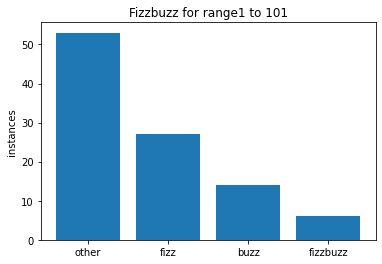

In [35]:
#
# Histogram of fizzbuzz
#
from collections import Counter


def fizz_buzz_classify(x: int) -> Vector:
    """output will be a one-hot encoding of the fizzbuzz representation of the number"""
    if x % 15 == 0:
        return 'fizzbuzz'
    elif x % 5 == 0:
        return 'buzz'
    elif x % 3 == 0:
        return 'fizz'
    else:
        return 'other'

range_min = 1
range_max = 101
trX = [n for n in range(range_min, range_max)]
trY = [fizz_buzz_classify(n) for n in trX]

my_dic = Counter(trY)
print(my_dic)

# plot bars with left x-coordinates [xs], heights [num_oscars]
plt.bar(my_dic.keys(), my_dic.values())

plt.ylabel("instances")   # label y-axis
plt.title("Fizzbuzz for range" + str(range_min) + ' to ' + str(range_max))     # graph title

# label x-axis with movie names at bar centers
#plt.xticks([i + 0.5 for i, _ in enumerate(my_dic.keys())], my_dic.keys())
plt.xticks([i for i, _ in enumerate(my_dic.keys())], my_dic.keys())
plt.show()